## State

First, define the State of the graph.

The State Schema serves as the input schema for all Nodes and Edges in the graph.

Lets use the TypedDict class from python's typing module as our schema, which providestype hints for the keys.

In [1]:
from typing_extensions import TypedDict
class State(TypedDict):
    graph_state:str

## Nodes

Nodes are just python functions.

The first positional argument is the state, as defined above.

Because the state is a TypedDict with schema as defined above, each node can access the key, graph_state with state['graph_state'].

Each node returns a new value of the state key graph_state.

By defaults, the new value returned by each node will override the prior state value.

In [2]:
def first_node(state):
    print("My First Node is called")
    return {"graph_state": state['graph_state']+" I am playing"}

def second_node(state):
    print("My Second Node is called")
    return {"graph_state":state['graph_state']+" Cricket"}

def third_node(state):
    print("My Third Node is called")
    return{"graph_state":state['graph_state']+ " Badminton"}

## Edges

Edges connect the nodes.
Normal Edges are used if you want to always go from, for example- node_1 to node_2.

Conditional Edges are used if you want to optionally route between nodes.

Conditional edges are implemented as functions that return the next nodes to visit based upon the some logic.

In [3]:
import random
from typing import Literal

def decide_play(state)->Literal['second_node', 'third_node']:
    graph_state=state['graph_state']

    if random.random()<0.5:
        return "second_node"

    return "third_node"



## Graph

#### Graph Construction

Now, we build the graph from our components defined above.

The StateGraph class is the graph class that we can use.

First, we initialize a StateGraph with the State class we defined above.

Then, we add our nodes and edges.

We use the START Node, a special node that sends user input to the graph, to indicatewhere to start our graph.

The END Node is a special node that represents a terminal node.

Finally, we compile our graph to perform a few basics checks on the graph structure.

We can visualize the graph as Mermaid diagram.


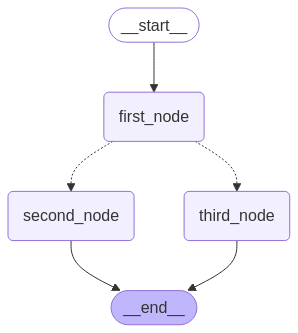

In [4]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

## Build Graph
builder=StateGraph(State)

builder.add_node("first_node",first_node)
builder.add_node("second_node",second_node)
builder.add_node("third_node",third_node)

## Logic
builder.add_edge(START,"first_node")
builder.add_conditional_edges("first_node",decide_play)
builder.add_edge("second_node",END)
builder.add_edge("third_node",END)

## Add
graph=builder.compile()

## View
display(Image(graph.get_graph().draw_mermaid_png()))

## Graph Invocation

The compiled graph implements the runnanble protocol.

This provides a standard way to execute LangChain components.

Invoke is one of the standard methods in this interface.

The input is dictionary{"graph_state":"Hi, this is lance"}, which sets the inital grpah state dict.

When invode is called, the graph starts execution from the START node.

It progresses through the defined nodes(nodes_1, node_2, node_3) in order.

The conditional edge will traverse from node 1 to node 2 or 3 using a 50/50 decision rule.

Each node function receives the current state and returns a new value, which overrides the graph state.

The execution continues untill it reaches the END node.

In [5]:
graph.invoke({"graph_state":"Hi, My name is Deepak"})

My First Node is called
My Third Node is called


{'graph_state': 'Hi, My name is Deepak I am playing Badminton'}

# Basic Chatbot

In [6]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

In [7]:
class State(TypedDict):
    messages:Annotated[list, add_messages]

In [8]:
graph_builder=StateGraph(State)

In [9]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")

In [10]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x000001882B0F7470>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x000001882B11C650>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [11]:
def chatbot(state:State):
    return {"messages":[llm.invoke(state["messages"])]}

In [12]:
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START,"chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

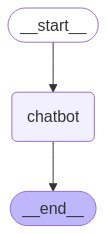

In [13]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

In [18]:
while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)

    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

Assistant: Hello! 👋

How can I help you today?

Assistant: I do know about LangGraph! It's a fascinating project. 

Here's what I understand about LangGraph:

* **It's a large-scale multilingual language model.** Like me, it's trained on a massive dataset of text and code, enabling it to understand and generate human-like text in multiple languages.

* **It's focused on representing languages as graphs.** This means it sees relationships between words and concepts in a more structured way than traditional word embeddings. This graph-based approach can be beneficial for tasks like:
    * **Cross-lingual transfer learning:**  Leveraging knowledge from one language to improve performance in another.
    * **Semantic understanding:**  Capturing the deeper meaning and relationships between words.
    * **Generating creative text formats:**  Producing different kinds of text, like poems, code, scripts, musical pieces, email, letters, etc.

* **It's open-source.** This means that researchers 